# Simulation 

In [1]:
import numpy as np
import scipy.stats
from scipy import stats
import matplotlib
matplotlib.use("Agg")
import matplotlib.animation as animation
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.cm as cmx
import matplotlib.colors as colors


## Functions

### Functions: Algorithm

In [2]:
def prior_energy(G,node,z):
    # needs state z, 
    # counts number of non-matches.. non matches increase energy 
    neighbor_voxel_matches = 0
    for edge in G.edge[node]:
        if z!=G.node[edge]['state']:
            neighbor_voxel_matches+=1
    return(neighbor_voxel_matches* G.graph['B'])



In [3]:
def liklihood_energy(G,node,z):
    k = G.graph['tp']
    Sigma = np.eye(k)*G.graph['sigma_true'] # use true sigma for now 
    u = G.graph['u_est'][:,z][np.newaxis] # 1x time points
    x =  G.node[node]['x'] # 1 x time points
    lik_en = -0.5*np.log(np.linalg.det(Sigma)) - 0.5*np.dot(np.dot((u-x),np.linalg.inv(Sigma)),(u-x).T) - k/2.0*np.log(2.0*np.pi)
    return(lik_en)


In [4]:
def node_conditional(G,node,prior_or_posterior):
    energy_per_state =  np.zeros(G.graph['num_states'])
    for s,state in enumerate(range(G.graph['num_states'])):
        if prior_or_posterior=='posterior':
            lik_energy=liklihood_energy(G,node,state)
        elif prior_or_posterior=='prior':
            lik_energy=0
        energy_per_state[s] = np.exp(-1.0*prior_energy(G,node,state)+lik_energy)
    return(energy_per_state/energy_per_state.sum())
                                     

In [5]:

#### Gibbs sample from prior 
def gibbs_sample(G,num_gibbs_samples=500,prior_or_posterior='prior'):
    nn = G.graph['nn']
    posterior_samples = np.zeros((nn*nn,num_gibbs_samples))
    for samples in range(num_gibbs_samples):
        for n,node in enumerate(G.nodes()):
            cond_probs = node_conditional(G,node,prior_or_posterior)
            G.node[node]['state']=np.where(np.random.multinomial(1,cond_probs))[0][0]
            posterior_samples[n,samples] = G.node[node]['state']
    return(G,posterior_samples)


In [6]:

#### ICM 
def ICM(G,num_gibbs_samples=40,prior_or_posterior='posterior'):
    nn = G.graph['nn']
    for samples in range(num_gibbs_samples):
        for n,node in enumerate(G.nodes()):
            cond_probs = node_conditional(G,node,prior_or_posterior)
            G.node[node]['state_k+1']=np.argmax(cond_probs)
        for n,node in enumerate(G.nodes()):
            G.node[node]['state']=G.node[node]['state_k+1']
            
    return(G)


### Functions: Algorithm (2.0) Estimating B

In [7]:
def prior_energy2(G,node,z,B):
    # needs state z, 
    # counts number of non-matches.. non matches increase energy 
    neighbor_voxel_matches = 0
    for edge in G.edge[node]:
        if z!=G.node[edge]['state']:
            neighbor_voxel_matches+=1.0
    return(neighbor_voxel_matches* B)


In [8]:
def node_conditional2(G,node,B):
    energy_per_state =  np.zeros(G.graph['num_states'])
    for s,state in enumerate(range(G.graph['num_states'])):
        energy_per_state[s] = np.exp(-1.0*prior_energy2(G,node,state,B))
    return(energy_per_state/energy_per_state.sum())
                                     

In [9]:
def Z(G,node,B):
    energy_per_state =  np.zeros(G.graph['num_states'])
    for s,state in enumerate(range(G.graph['num_states'])):
        energy_per_state[s] = np.exp(-1.0*prior_energy2(G,node,state,B))
    return(energy_per_state.sum())
                                     

In [10]:
def min_for_B(BB):
    total = 0
    for sample in range(num_samples-1):
        for n,node in enumerate(G.node):
            state = posterior_samples[n,sample]
            total+=np.log(node_conditional2(G,node,BB))[state]
    total = total/num_samples
    return(-1.0*total)

In [11]:
def min_for_B2(BB):
    total = 0
    for sample in range(num_samples-1):
        for n,node in enumerate(G.node):
            state = posterior_samples[n,sample]
            total+=-1.0*prior_energy2(G,node,state,BB)-np.log(Z(G,node,BB))
    total = total/num_samples
    return(-1.0*total)

### Functions: Simulations

In [12]:
def generate_mean_time_series(timepoints):
    u =np.random.normal(size=timepoints)
    return(u)

def generate_x_from_mean(u,sigma,samples):
    E = np.eye(len(u))*sigma
    x = np.random.multivariate_normal(u,E,size=samples)
    return(x)


In [13]:

def generate_mean_time_series_normalized(n,rho,e,how_to_norm=1):
    u = np.zeros(n)
    u[0]=np.random.normal(1)
    for i in np.array(range(n-1))+1:
        u[i] = u[i-1]*rho + np.random.normal(0,e)
        
    u = u-u.mean() # 0-mean
    if how_to_norm==1:
        u = u/np.linalg.norm(u,2) # unit-norm
    elif how_to_norm==2:
        u = u/u.std()
    else:
        u = u
    return(u)


In [14]:

def generate_x_from_mean_single_normalized(u,t,SNR,how_to_norm=1):
    x = np.zeros(t)
    x = u+np.random.normal(0,SNR,t)
    x = x-x.mean() # 0-mean
    if how_to_norm==1:
        x = x/np.linalg.norm(x,2) # unit-norm
    elif how_to_norm==2:
        x = x/x.std() # std
    else:
        x = x    
    return(x)


In [15]:
### Generate Data ### 
def add_data_to_graph(G,tp=3,sigma=1,normalized=False):


    X = np.zeros((tp,G.graph['nn']**2))
    u = np.empty((tp,G.graph['num_states']))
    
    for ui in range(G.graph['num_states']):
        u[:,ui] =generate_mean_time_series(tp)
        #if normalized


    states = np.array([])
    for ni,n in enumerate(G.node):

        x = generate_x_from_mean(u[:,G.node[n]['state']],sigma,1)
        states = np.append(states,G.node[n]['state'])
        X[:,ni] = x
        G.node[n]['x'] = x


    G.graph['u_true'] = u
    G.graph['sigma_true'] = sigma
    G.graph['X'] = X

    # Generate Random Estimates
    u_est = np.empty((tp,G.graph['num_states']))
    for ui in range(G.graph['num_states']):
        u_est[:,ui] =generate_mean_time_series(tp)
    G.graph['u_est'] = u_est
    
    G.graph['tp'] = tp
    G.graph['states'] = states
    
    return(G)


In [16]:
def assess_perf(G):

    # for true states, find all matching nodes. 
    for node1 in G.nodes():
        state1 = G.node[node1]['true_state']
        G.node[node1]['matching_nodes_true'] = []
        for node2 in G.nodes():
            state2 = G.node[node2]['true_state']
            if state1==state2:
                G.node[node1]['matching_nodes_true'].append(node2)

    for node1 in G.nodes():
        state1 = G.node[node1]['state']
        G.node[node1]['matching_nodes'] = []
        for node2 in G.nodes():
            state2 = G.node[node2]['state']
            if state1==state2:
                G.node[node1]['matching_nodes'].append(node2)            

    # another graph 
    matches = np.empty(G.graph['nn']**2)
    for ni,node1 in enumerate(G.nodes()):
        matches[ni]=len(set(G.node[node1]['matching_nodes']).intersection(set(G.node[node1]['matching_nodes_true'])))


    return(matches.sum())

### Functions: Plotting

In [17]:
### Change Color 
def change_node_color(G,changeto):
    
    for node in G.node:
        G.node[node]['state'] = changeto[G.node[node]['state']]
    
    return(G)




In [18]:
def plot_graph(G):
    im = np.empty((G.graph['nn'],G.graph['nn']))
    for node in G.node:
        im[node]=G.node[node]['state']

    imm = plt.imshow(im,interpolation='None',origin='lower')
    return(imm)


In [19]:
def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color


## Simulation

### Generate 'True' Network labels by sampling from the potts model (prior) with Gibbs Sampling

45294.0


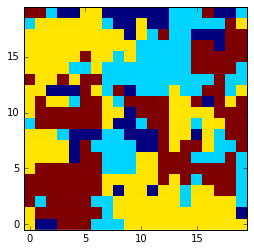

In [49]:
### Initialize Graph 
nn=20
num_nodes = nn*nn
G=nx.grid_2d_graph(nn,nn)  #4x4 grid
G.graph['B'] = 1.1
G.graph['num_states'] = 4
G.graph['nn']=nn
sigma = 1
# randomize initialize states 
for n in G.node:
    state=np.random.randint(G.graph['num_states'])
    G.node[n]['state']=state

    
G,posterior_samples = gibbs_sample(G,100)
    
G = add_data_to_graph(G,3,sigma)
G.graph['X'].shape

for n in G.node:
    G.node[n]['true_state']=G.node[n]['state']
plt.figure()
plot_graph(G)
print(assess_perf(G))


### Randomize Network Labels (to give to algorithm)

11490.0


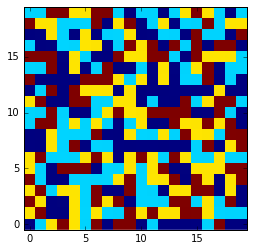

In [50]:
# randomize starting position 
for n in G.node:
    state=np.random.randint(G.graph['num_states'])
    G.node[n]['state']=state
plt.figure()
plot_graph(G)

print(assess_perf(G))

### Visualize Unnormalized X data 

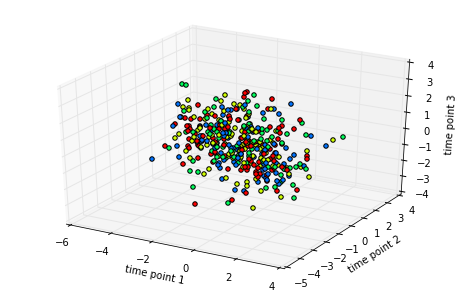

In [51]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
cmap = get_cmap(G.graph['num_states']+2)

for node in G.node:
    x = G.node[node]['x']
    state = G.node[node]['state']
    ax.scatter(x[0,0], x[0,1], x[0,2], c=cmap(state))
    
ax.set_xlabel('time point 1')
ax.set_ylabel('time point 2')
ax.set_zlabel('time point 3')

### Visualize normalized X data (not used in this simulation)

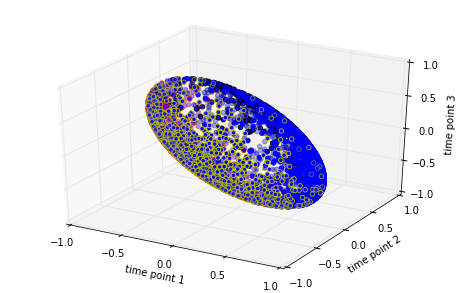

In [52]:
#### Using Unit Normalization. 

t = 4
n = 5000
clusters = 4
X = np.zeros((t,n))
u = np.empty((t,n))
l = np.empty((n))
corr = 0.6
e = 0.4
SNR = .6
for ui in range(clusters):
    u[:,ui] =generate_mean_time_series_normalized(t,corr,e)

    
for xi in range(n): 
    clust = np.random.randint(clusters)
    x = generate_x_from_mean_single_normalized(u[:,clust],t,SNR)
    X[:,xi] = x
    l[xi] = clust

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
cols = ['b','y','r','k']
for c in range(clusters):
    ax.scatter(X[0,l==c],X[1,l==c], X[2,l==c],color=cols[c])

ax.set_xlabel('time point 1')
ax.set_ylabel('time point 2')
ax.set_zlabel('time point 3')

### Cluster Data using K-means 

29010.0


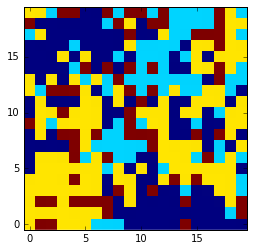

In [53]:
from sklearn.cluster import KMeans 
kmeans = KMeans(G.graph['num_states'])
results = kmeans.fit(G.graph['X'].T)
labels = results.fit_predict(G.graph['X'].T)

# set states
for ni,n in enumerate(G.node):
    G.node[n]['state']=labels[ni]

# set centroids 
G.graph['u_est'] = results.cluster_centers_.T
plot_graph(G)
print(assess_perf(G))

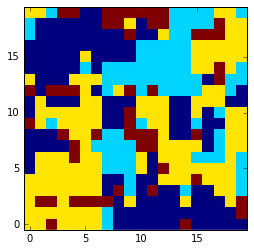

In [54]:
G,posterior_samples = gibbs_sample(G,100,prior_or_posterior='posterior')
plot_graph(G)

In [55]:
print(assess_perf(G))

33742.0


### Cluster Data using Current Model (Monte-Carlo EM)

0
1
2
3
4
5
6
7
8
9


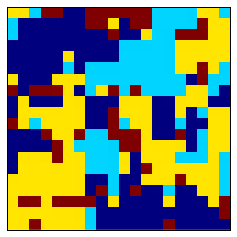

In [56]:
### EM 

#perf = 
### Movie of Sampling from posterior
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
im = np.empty((G.graph['nn'],G.graph['nn']))
for node in G.node:
    im[node]=G.node[node]['state']

imm = plt.imshow(im,interpolation='None',origin='lower')

G.graph['Bstore'] = np.array([])

#with writer.saving(fig, "em_sampling.mp4", 100):
#    writer.grab_frame()

for em_step in range(10):
        ### E step - 
        ### Get posterior P(Z|Z_n,X)
    print(em_step)
    num_samples=50
    G,posterior_samples = gibbs_sample(G,100,prior_or_posterior='posterior')
    posterior_samples = posterior_samples[:,-1*num_samples:-1]
        
        ### show samples from posterior 
        #for i in range(10):

        #    G,posterior_samples2 = gibbs_sample(G,1,prior_or_posterior='posterior')
        #    temp = np.empty((G.graph['nn'],G.graph['nn']))
        #    for node in G.node:
        #        temp[node]=G.node[node]['state']
        #    imm.set_data(temp)
        #    writer.grab_frame()



        #### M step
        
        ### Estimate U
    u_est_new =G.graph['u_est']
    u_est_new_count = G.graph['u_est']*0.0+1.0

    for sample in range(num_samples-1):
        for n,node in enumerate(G.node):
            state = posterior_samples[n,sample] # node was in this state
            u_est_new[:,int(state)] += G.node[node]['x'][0,:] # add the x data to that time vector
            u_est_new_count[:,int(state)] += np.ones(G.graph['tp'])
    u_est_new = u_est_new/u_est_new_count
    G.graph['u_est'] = u_est_new
        
        ### Estimate Sigma (pooled across clusters)
        
        ### Estimate B
    val = np.array([])
    brange = np.arange(0.1,1.8,.1)
    for b in brange:
        val = np.append(val,min_for_B2(b))
        newb = brange[np.argmin(val)]
    G.graph['B'] = newb
    G.graph['Bstore'] = np.append(G.graph['Bstore'],newb)
    G.graph['u_est'] = u_est_new


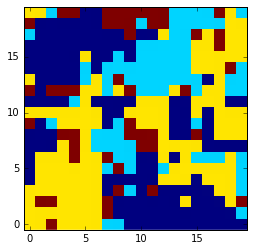

In [57]:
plot_graph(G)

In [58]:
G.graph['Bstore']

array([ 1.1,  1.1,  1. ,  1.1,  1. ,  1. ,  1. ,  1.1,  1. ,  1. ])

### Perform Iterated Conditional Modes

36184.0


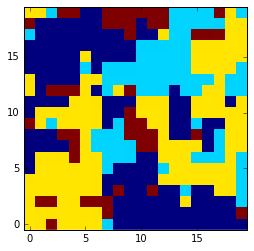

In [59]:
ICM(G,num_gibbs_samples=40,prior_or_posterior='posterior')
plot_graph(G)
print(assess_perf(G))

### Save a movie of sampling from the posteior 

In [ ]:
### Movie of Sampling from posterior
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
im = np.empty((G.graph['nn'],G.graph['nn']))
for node in G.node:
    im[node]=G.node[node]['state']

imm = plt.imshow(im,interpolation='None',origin='lower')
#im.set_clim([0,1])


with writer.saving(fig, "posterior_sampling.mp4", 100):
    for i in range(100):
        writer.grab_frame()
        G,posterior_samples = gibbs_sample(G,1,prior_or_posterior='posterior')
        temp = np.empty((G.graph['nn'],G.graph['nn']))
        for node in G.node:
            temp[node]=G.node[node]['state']
        imm.set_data(temp)

### Recovery of Hidden States is good. 

## Additional Stuff

### Movie of Sampling from Potts Model

In [ ]:
### Movie of Sampling from Prior different B'
### Initialize Graph 
nn=20
for BB in [0.2,0.5,1,1.2,1.5,1.7]:
    num_nodes = nn*nn
    G=nx.grid_2d_graph(nn,nn)  #4x4 grid
    G.graph['B'] = BB
    G.graph['num_states'] = 4
    G.graph['nn']=nn
    # randomize initialize states 
    for n in G.node:
        state=np.random.randint(G.graph['num_states'])
        G.node[n]['state']=state



    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='Movie Test', artist='Matplotlib',
                    comment='Movie support!')
    writer = FFMpegWriter(fps=10, metadata=metadata)


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = np.empty((G.graph['nn'],G.graph['nn']))
    for node in G.node:
        im[node]=G.node[node]['state']

    imm = plt.imshow(im,interpolation='None',origin='lower')
    #im.set_clim([0,1])


    with writer.saving(fig, "sample_prior"+str(BB)+".mp4", 100):
        for i in range(100):
            G,posterior_samples = gibbs_sample(G,1)
            temp = np.empty((G.graph['nn'],G.graph['nn']))
            for node in G.node:
                temp[node]=G.node[node]['state']
            imm.set_data(temp)
            writer.grab_frame()

## Fixed my Estimation of B !

In [ ]:
### Initialize Graph 

for BB in [0.2,0.5,1,1.2,1.5,1.7]:
    nn=15
    num_nodes = nn*nn
    G=nx.grid_2d_graph(nn,nn)  #4x4 grid
    G.graph['B'] = BB
    G.graph['num_states'] = 4
    G.graph['nn']=nn
    sigma = 1
    # randomize initialize states 
    for n in G.node:
        state=np.random.randint(G.graph['num_states'])
        G.node[n]['state']=state

    num_samples=50
    G,posterior_samples = gibbs_sample(G,100)
    posterior_samples = posterior_samples[:,-1*num_samples:-1]


    plt.figure()
    plot_graph(G)
    plt.figure()
    BBs = np.arange(0,2,.1)
    for b,bb in enumerate(BBs):
        plt.scatter(bb,min_for_B(bb))
    plt.axvline(x=BB)

In [ ]:
    nn=20
    num_nodes = nn*nn
    G=nx.grid_2d_graph(nn,nn)  #4x4 grid
    G.graph['B'] = 1
    G.graph['num_states'] = 4
    G.graph['nn']=nn
    sigma = 1
    # randomize initialize states 
    for n in G.node:
        state=np.random.randint(G.graph['num_states'])
        G.node[n]['state']=state

    num_samples=100
    G,posterior_samples = gibbs_sample(G,100)
    posterior_samples = posterior_samples[:,-1*num_samples:-1]

    BBs = np.arange(0,3,.01)
    for b,bb in enumerate(BBs):
        plt.scatter(bb,min_for_B2(bb))

In [ ]:
len(G.node)

In [ ]:
from scipy.optimize import minimize
x0=1
#res = minimize(min_for_B, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

In [ ]:
res.values()

In [ ]:
val = np.array([])
brange = np.arange(0.1,1.8,.1)
for b in brange:
    val = np.append(val,min_for_B2(b))
newb = brange[np.argmin(val)]
print(newb)